### Sentiment Analysis with Different Deep Learning Techniques
#### FRE9733 - Homework 11
#### Deniz Kural - dk3703

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D,Conv1D,LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
file_list = glob.glob(os.path.join(os.getcwd(), r"C:\Users\deniz\Downloads\review_polarity\txt_sentoken\neg", "*.txt"))

corpus_neg = []

for file_path in file_list:
    with open(file_path) as f_input:
        corpus_neg.append(f_input.read())

df_neg=pd.DataFrame(corpus_neg,columns=["Text"])
df_neg["Sentiment"]=0

In [3]:
file_list = glob.glob(os.path.join(os.getcwd(), r"C:\Users\deniz\Downloads\review_polarity\txt_sentoken\pos", "*.txt"))

corpus_pos = []

for file_path in file_list:
    with open(file_path) as f_input:
        corpus_pos.append(f_input.read())
        
df_pos=pd.DataFrame(corpus_pos,columns=["Text"])
df_pos["Sentiment"]=1

In [4]:
df_all=pd.concat([df_pos,df_neg])

In [5]:
df_all.head()

,Text,Sentiment
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,you've got mail works alot better than it dese...,1
3,""" jaws "" is a rare film that grabs your atten...",1
4,moviemaking is a lot like being the general ma...,1


In [6]:
df_all.tail()

,Text,Sentiment
995,"if anything , "" stigmata "" should be taken as ...",0
996,"john boorman's "" zardoz "" is a goofy cinematic...",0
997,the kids in the hall are an acquired taste . \...,0
998,there was a time when john carpenter was a gre...,0
999,two party guys bob their heads to haddaway's d...,0


We will have 1000 positive and negative sentiment as expected. '0' represents the movie reviees with negative sentiment and '1' represents the movies with positive sentiment.

In [7]:
df_all["Sentiment"].value_counts()

0    1000
1    1000
Name: Sentiment, dtype: int64

<AxesSubplot:xlabel='Sentiment', ylabel='count'>

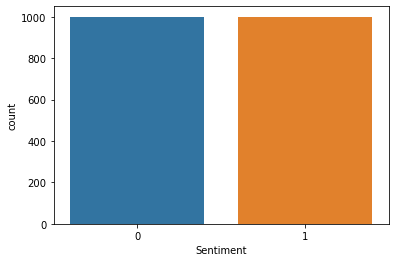

In [8]:
sns.countplot(x='Sentiment', data=df_all)

Here, we can observe an example from our dataframe where the second movie review can be seen. As we can see, we have lots of multiple spacings, punctuations. Thus, we need to clean and handle these unstructured data scuh that it would be easier for us to use.

In [9]:
print(df_all.iloc[2,:][0])

you've got mail works alot better than it deserves to . 
in order to make the film a success , all they had to do was cast two extremely popular and attractive stars , have them share the screen for about two hours and then collect the profits . 
no real acting was involved and there is not an original or inventive bone in it's body ( it's basically a complete re-shoot of the shop around the corner , only adding a few modern twists ) . 
essentially , it goes against and defies all concepts of good contemporary filmmaking . 
it's overly sentimental and at times terribly mushy , not to mention very manipulative . 
but oh , how enjoyable that manipulation is . 
but there must be something other than the casting and manipulation that makes the movie work as well as it does , because i absolutely hated the previous ryan/hanks teaming , sleepless in seattle . 
it couldn't have been the directing , because both films were helmed by the same woman . 
i haven't quite yet figured out what i like

#### Data Cleaning Stage
At this stage, we remove the html tags, punctuations, numbers and multiple spaces. Moreover, the single letters caused by removal of punctuations or other operations are removed in the next function. This will cause another extra spacing between words which is alos taken care of the *preprocess_text* function. 

In [10]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)


def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [11]:
X = []
sentences = list(df_all['Text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [12]:
X[2]

'you ve got mail works alot better than it deserves to in order to make the film success all they had to do was cast two extremely popular and attractive stars have them share the screen for about two hours and then collect the profits no real acting was involved and there is not an original or inventive bone in it body it basically complete re shoot of the shop around the corner only adding few modern twists essentially it goes against and defies all concepts of good contemporary filmmaking it overly sentimental and at times terribly mushy not to mention very manipulative but oh how enjoyable that manipulation is but there must be something other than the casting and manipulation that makes the movie work as well as it does because absolutely hated the previous ryan hanks teaming sleepless in seattle it couldn have been the directing because both films were helmed by the same woman haven quite yet figured out what liked so much about you ve got mail but then again is that really impor

As we can see from the above example, all of the punctuations, single letters are removed from the dataset.

#### Split data into train & test


In [13]:
# Split data into train & test
seed=3
X_train, X_test, y_train, y_test = train_test_split(df_all['Text'], df_all['Sentiment'], test_size=250, random_state=seed, 
                                                    stratify=df_all['Sentiment'])
# Append sentiment back using indices
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [14]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

#### Padding for both training and testing sets

In [15]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [16]:
vocab_size

40995

We have 40995 unique words in our corpus.

###  GloVe embeddings to create our feature matrix

In [17]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open(r"C:\Users\deniz\Downloads\glove.6B\glove.6B.100d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()
    

we will create an embedding matrix where each row number will correspond to the index of the word in the corpus

In [18]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### First Model : Simple Neural Network

In [19]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          4099500   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 4,109,501
Trainable params: 10,001
Non-trainable params: 4,099,500
_________________________________________________________________
None


In [21]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)


Epoch 1/6
11/11 [==============================] - 3s 223ms/step - loss: 0.8337 - acc: 0.4927 - val_loss: 0.7062 - val_acc: 0.5629
Epoch 2/6
11/11 [==============================] - 0s 13ms/step - loss: 0.6419 - acc: 0.6188 - val_loss: 0.6770 - val_acc: 0.6000
Epoch 3/6
11/11 [==============================] - 0s 13ms/step - loss: 0.5615 - acc: 0.7322 - val_loss: 0.6619 - val_acc: 0.6086
Epoch 4/6
11/11 [==============================] - 0s 13ms/step - loss: 0.4814 - acc: 0.8085 - val_loss: 0.6784 - val_acc: 0.6057
Epoch 5/6
11/11 [==============================] - 0s 13ms/step - loss: 0.4208 - acc: 0.8637 - val_loss: 0.6575 - val_acc: 0.6086
Epoch 6/6
11/11 [==============================] - 0s 14ms/step - loss: 0.3687 - acc: 0.9243 - val_loss: 0.6436 - val_acc: 0.6229


We observe 0.9243 accuracy in the training set and 0.6229 accuracy in the validation set where we select the size of validation set is 20% of the defined training set.

In [22]:
score = model.evaluate(X_test, y_test, verbose=1)


8/8 [==============================] - 0s 3ms/step - loss: 0.6738 - acc: 0.6200


**Comment:**
<br>
When we evaluate the test set, we can observe an accuracy of 0.6200 which is quite low if we compare it with the training accuracy which indicates high variance in our dataset and we can say that our model is overfitting the data we have. 

In [23]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6737781167030334
Test Accuracy: 0.6200000047683716


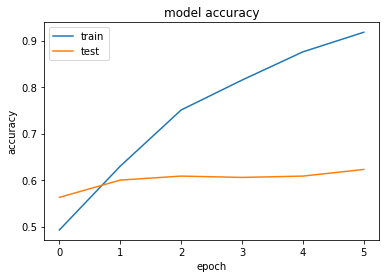

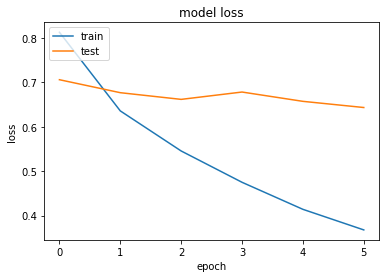

In [24]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

**Comment:**
<br>From these figures, we can see that training sets accuracy is much higher for training set and also, the loss is much less for training set if we compare it with the test set. Thus, we can say that our model is overfitting on the training set and we have a variance problem in our model. Although we get significantly high accuracy value for training set, the accuracy of test set is considerably low. Thus, we can say that the model is not doing so well on this classification task and it needs much more data or some kind of regularization method in order to reduce variance.

### Second Model: Convolutional Neural Network 

In [25]:
#1D Convolutional Neural Network with 1 Conv. and 1 POoling layer

In [26]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [27]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          4099500   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 4,163,757
Trainable params: 64,257
Non-trainable params: 4,099,500
_________________________________________________________________
None


In [28]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
11/11 [==============================] - 2s 131ms/step - loss: 0.7769 - acc: 0.5263 - val_loss: 0.7092 - val_acc: 0.5371
Epoch 2/6
11/11 [==============================] - 1s 76ms/step - loss: 0.6570 - acc: 0.5610 - val_loss: 0.6544 - val_acc: 0.6086
Epoch 3/6
11/11 [==============================] - 1s 94ms/step - loss: 0.5751 - acc: 0.7207 - val_loss: 0.6380 - val_acc: 0.6400
Epoch 4/6
11/11 [==============================] - 1s 97ms/step - loss: 0.5298 - acc: 0.7812 - val_loss: 0.6228 - val_acc: 0.6857
Epoch 5/6
11/11 [==============================] - 1s 83ms/step - loss: 0.4762 - acc: 0.9008 - val_loss: 0.6157 - val_acc: 0.7057
Epoch 6/6
8/8 [==============================] - 0s 9ms/step - loss: 0.6101 - acc: 0.7040


**Comments:**
<br>
We have got training accuracy of 0.9341 and validation accuracy of 0.7057, which is lower than simple neural network. This is due to the small size of input dataset if we consider the amount of required data that CNN requires for good accuracies which is generally quite large. So, simple neural network is able to outperform the CNN in this case.

In [29]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6101494431495667
Test Accuracy: 0.7039999961853027


**Comments:**
<br>When we analyze the test score, we found out that CNN model does better slightly if we compare it with the simple neural network model. Test score accuracy is the most important metric for us as it is the metric for testing  the model with out of sample data. Thus, we will prefer CNN over simple neural network model. However, we still observe the difference between the test set accuracy and train set accuracy which indicates overfittin of the model and hihg variance problem.

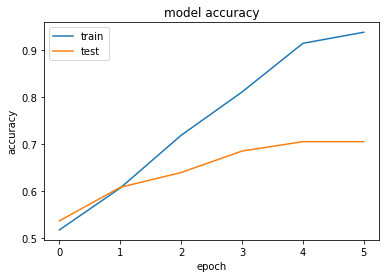

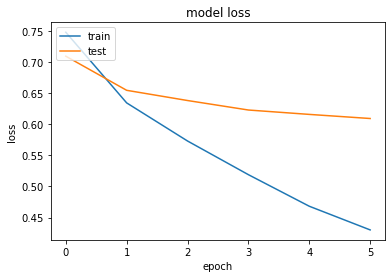

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

We observe the last mentioned comments from the Figures as well which is high variance problem at the result. We still do not have a good accuracy for our model which is about 66%.

### Third Model: LSTM Model

In [31]:
#LSTM Network with layer size of 128

In [32]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))


model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [33]:
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          4099500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 4,216,877
Trainable params: 117,377
Non-trainable params: 4,099,500
_________________________________________________________________
None


In [34]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
11/11 [==============================] - 9s 426ms/step - loss: 0.6951 - acc: 0.5268 - val_loss: 0.6836 - val_acc: 0.5657
Epoch 2/6
11/11 [==============================] - 4s 344ms/step - loss: 0.6719 - acc: 0.5896 - val_loss: 0.7162 - val_acc: 0.4800
Epoch 3/6
11/11 [==============================] - 3s 293ms/step - loss: 0.6460 - acc: 0.6158 - val_loss: 0.6660 - val_acc: 0.5857
Epoch 4/6
11/11 [==============================] - 3s 295ms/step - loss: 0.6017 - acc: 0.6661 - val_loss: 0.5796 - val_acc: 0.7057
Epoch 5/6
11/11 [==============================] - 4s 344ms/step - loss: 0.5579 - acc: 0.7197 - val_loss: 0.5515 - val_acc: 0.7229
Epoch 6/6
8/8 [==============================] - 0s 41ms/step - loss: 0.6429 - acc: 0.6080


In this model, we have much lower training accuracy and also less validation accuracy if we compare it with other models. However, the difference between them is decreased which the main cause of variance problem. Thus, the model is less overfitting now. The training accuracy is 0.6890 and the validation accuracy is 0.6343. 

In [35]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6428993940353394
Test Accuracy: 0.6079999804496765


The test accuracy seems to be also lower than the other models' results. Thus, LSTM model is the worst performing model among these three models for this dataset. 

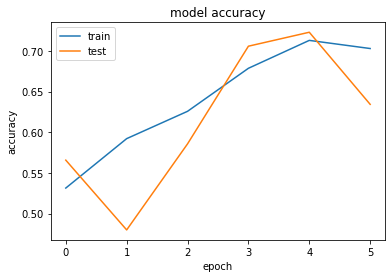

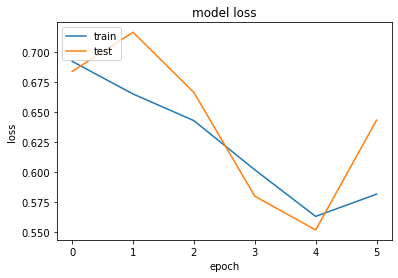

In [36]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

We can observe that there is less overfitting with this model. However, the accuracy is decreased significantly.

### Comments & Results:

**Best Model:** The best model for these hyperparameters and with these dataset is 1D CNN which shows us 0.7039 test accuracy and 0.9341 training set accuracy. Again, we can conclude that these method causes overfitting as there is significant gap between training and test set accuracies. This problem can be solved in several ways:
- More input data
- Regularization methods such as L2, dropout and data augmentation
- Neural Network architecture change, Hyperparameter search